In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

C:\Users\Kerols\anaconda3\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
train_data= pd.read_csv('dataset/train.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: >

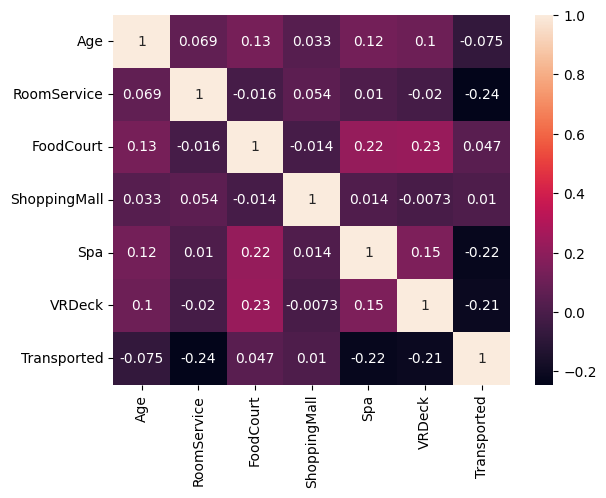

In [4]:
sns.heatmap(train_data.select_dtypes(include=['float64','bool']).corr(),annot=True)

In [5]:
train_data['CryoSleep'].value_counts(dropna=False)

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

In [6]:
train_data[train_data['CryoSleep']== True][['Transported']].value_counts()

Transported
True           2483
False           554
Name: count, dtype: int64

In [7]:
train_data[train_data['CryoSleep']== False][['Transported']].value_counts()

Transported
False          3650
True           1789
Name: count, dtype: int64

In [8]:
train_data[train_data['CryoSleep'].isna()][['Transported']].value_counts()

Transported
False          111
True           106
Name: count, dtype: int64

**CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.**

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.**

**the people in cryo sleep should to spend 0 let us cheaking that by calcatung the total spend first then then see if there is a realtion**

In [10]:
sum_values = [train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].iloc[i].sum() for i in range(len(train_data))]
## we add it prematily to cheak our theory
train_data['total_spend']=sum_values

In [11]:
print(train_data[train_data['CryoSleep'] == True ][['total_spend']].value_counts(dropna=False))
print(f'total is {train_data[train_data['CryoSleep'] == True ][['total_spend']].value_counts(dropna=False).sum()}')
print('-----------------------')
print(train_data[train_data['CryoSleep'] == False ][['total_spend']].value_counts(dropna=False))
print(f'total is {train_data[train_data['CryoSleep'] == False ][['total_spend']].value_counts(dropna=False).sum()}')

total_spend
0.0            3037
Name: count, dtype: int64
total is 3037
-----------------------
total_spend
0.0            518
809.0           54
788.0           39
804.0           39
803.0           34
              ... 
2343.0           1
2342.0           1
2341.0           1
2339.0           1
35987.0          1
Name: count, Length: 2298, dtype: int64
total is 5439


**We can say for sure anyone in cryo sleep spend 0$ and 1/10 of people not in cryo sleep spend 10 also se we can fill nulls here with some logic by saying anyone spend 0 is on cryosleep**

In [13]:
train_data[train_data['CryoSleep'].isna()][['total_spend']].value_counts()

total_spend
0.0            98
906.0           2
867.0           2
2599.0          2
787.0           2
               ..
925.0           1
923.0           1
907.0           1
904.0           1
16350.0         1
Name: count, Length: 115, dtype: int64

In [14]:
# Filter rows where 'CryoSleep' is NaN and 'total_spend' is 0.0
train_data[train_data['CryoSleep'].isna() & (train_data['total_spend'] > 0.0)][['CryoSleep']]

,CryoSleep
98,NaN
104,NaN
152,NaN
224,NaN
314,NaN
...,...
8420,NaN
8455,NaN
8591,NaN
8675,NaN


**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**Now we have a theory that is the most people at the same Groub_num have the same Transported statue and the people at the same family have the same to beacause they in same groub num so lets cheak that** 

In [17]:
#creating dataFrame to study our case 
IdandName=pd.concat([train_data['Name'].str.split(' ',expand=True),
                     train_data['PassengerId'].str.split('_',expand=True),
                     train_data['Transported']],axis=1)

IdandName.columns=['FirstName','LastName','Groub_num','Num_within_theGroub','Transported']


In [18]:
IdandName

,FirstName,LastName,Groub_num,Num_within_theGroub,Transported
0,Maham,Ofracculy,0001,01,False
1,Juanna,Vines,0002,01,True
2,Altark,Susent,0003,01,False
3,Solam,Susent,0003,02,False
4,Willy,Santantines,0004,01,True
...,...,...,...,...,...
8688,Gravior,Noxnuther,9276,01,False
8689,Kurta,Mondalley,9278,01,False
8690,Fayey,Connon,9279,01,True
8691,Celeon,Hontichre,9280,01,False


###  theory : The most of one group is from one Family "Most common" 

In [20]:
# Group by 'LastName' and collect unique 'Groub_num' values for each family
family_groups = IdandName.groupby('LastName')['Groub_num'].nunique()

# Filter families that are in more than one group
families_in_multiple_groups = family_groups[family_groups > 1]

# Display the result
if families_in_multiple_groups.empty:
    print("No family members are in different groups.")
else:
    print("Families in multiple groups:")
    print(families_in_multiple_groups)
    print('---------------------------')
    print(f'The repatiable destribution of last name is :{len(families_in_multiple_groups)} of {len(IdandName.LastName.unique())}')
    print(f'The repatiable destribution of one family in one group is :{families_in_multiple_groups.sum()} of {len(IdandName.Groub_num.unique())}')

Families in multiple groups:
LastName
Acobson        2
Acobsond       3
Adavisons      5
Adkinson       3
Aillyber       3
              ..
Wynneyerson    2
Yanton         5
Yatters        2
Yorkland       7
Youngrayes     3
Name: Groub_num, Length: 1664, dtype: int64
---------------------------
The repatiable destribution of last name is :1664 of 2218
The repatiable destribution of one family in one group is :5834 of 6217


In [21]:
# Count the number of each family
Families_count = IdandName.groupby('LastName').size()

# Sort for better readability
Families_count = Families_count.sort_values(ascending=False)

# Display the result
print(Families_count)

LastName
Casonston     18
Oneiles       16
Litthews      15
Domington     15
Garnes        14
              ..
Steen          1
Fandomatty     1
Robbson        1
Fanbox         1
Mcdon          1
Length: 2217, dtype: int64


In [22]:
# Get families in multiple groups
families_in_multiple_groups_detail = IdandName[IdandName['LastName'].isin(families_in_multiple_groups.index)]

# Group by 'LastName' and list the groups
family_group_details = families_in_multiple_groups_detail.groupby('LastName')['Groub_num'].unique()

print(family_group_details)

LastName
Acobson                                      [4220, 6905]
Acobsond                               [0991, 2220, 5671]
Adavisons                  [0192, 1425, 1766, 6509, 7303]
Adkinson                               [1778, 2970, 7786]
Aillyber                               [2204, 5152, 5179]
                                  ...                    
Wynneyerson                                  [0468, 8844]
Yanton                     [0641, 3997, 4212, 5127, 6968]
Yatters                                      [2075, 6446]
Yorkland       [0091, 0461, 0618, 2972, 3328, 5247, 8156]
Youngrayes                             [0960, 2264, 2369]
Name: Groub_num, Length: 1664, dtype: object


In [31]:
# Group by 'Groub_num' and count the unique 'LastName' values in each group
groups_with_multiple_families = (
    IdandName.groupby('Groub_num')['LastName']
    .nunique()  # Count unique last names
)

# Identify groups with more than one family
groups_with_multiple_families = groups_with_multiple_families[groups_with_multiple_families > 1]

# Display the result
if groups_with_multiple_families.empty:
    print("All groups consist of members from a single family.")
else:
    print("Groups with multiple families:")
    print(groups_with_multiple_families)

Groups with multiple families:
Groub_num
0020    3
0092    2
0099    2
0110    2
0140    2
       ..
8988    2
9034    2
9069    2
9157    2
9220    2
Name: LastName, Length: 249, dtype: int64


In [32]:
# Get detailed family breakdown for each group
group_family_details = IdandName.groupby('Groub_num')['LastName'].unique()

print(group_family_details)

Groub_num
0001      [Ofracculy]
0002          [Vines]
0003         [Susent]
0004    [Santantines]
0005     [Hinetthews]
            ...      
9275        [Conable]
9276      [Noxnuther]
9278      [Mondalley]
9279         [Connon]
9280      [Hontichre]
Name: LastName, Length: 6217, dtype: object


In [33]:
(IdandName.groupby('Groub_num')['LastName'].nunique()>1).value_counts()

LastName
False    5968
True      249
Name: count, dtype: int64

## So now we have an answer the most of groups from one family but it doesen't mean all families in one group and they can be in more than one group from that we can say last name is kind of important but the num of group give us more clarification about who trasfported and who's not so lets cheak it :

In [35]:
# Count the number of people in each group
people_per_group = IdandName.groupby('Groub_num').size()

# Sort for better readability
people_per_group = people_per_group.sort_values(ascending=False)

# Display the result
print(people_per_group)

Groub_num
4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Length: 6217, dtype: int64


In [36]:
# Group by 'Groub_num' and check if all 'Transported' values are the same in each group
all_destination_groups_prob = IdandName.groupby('Groub_num')['Transported'].nunique()
all_destination_groups_prob .value_counts()

Transported
1    5420
2     797
Name: count, dtype: int64

In [37]:
# Identify groups where there is more than one unique value for 'Transported' (meaning different destinations)
groups_with_different_destinations = all_destination_groups_prob [all_destination_groups_prob  > 1]
# Identify groups where there is  one unique value for 'Transported' (meaning same destinations)
groups_with_same_destinations = all_destination_groups_prob [all_destination_groups_prob  == 1]


# Display the result
if groups_with_different_destinations.empty:
    print("All people in each group have the same destination.")
else:
    print("Groups with people having different destinations:")
    print(f'{len( groups_with_different_destinations )} of {len(all_destination_groups_prob)}')
    print("groups with people having same  destinations: ")
    print(f'{len( groups_with_same_destinations )} of {len(all_destination_groups_prob)}')

Groups with people having different destinations:
797 of 6217
groups with people having same  destinations: 
5420 of 6217


## As we see the group num is high corr with transported so people with the same group have high chance to have the same transported statue lets cheak the precentage of each group :

In [39]:
# Group by 'Groub_num' and 'Transported' and calculate the count of occurrences
group_percentages = (
    IdandName.groupby(['Groub_num', 'Transported'])
    .size() 
    .unstack(fill_value=0) 
)

# Calculate percentages within each group
group_percentages = group_percentages.div(group_percentages.sum(axis=1), axis=0) * 100  # Normalize by the row sum to get percentages

# Create a new column 'Majority' to label whether the majority is transported or not
group_percentages['Majority'] = group_percentages.idxmax(axis=1)

# Display the result with the new Majority column
print(group_percentages)

Transported       False        True  Majority
Groub_num                                    
0001         100.000000    0.000000     False
0002           0.000000  100.000000      True
0003         100.000000    0.000000     False
0004           0.000000  100.000000      True
0005           0.000000  100.000000      True
...                 ...         ...       ...
9275          33.333333   66.666667      True
9276         100.000000    0.000000     False
9278         100.000000    0.000000     False
9279           0.000000  100.000000      True
9280          50.000000   50.000000     False

[6217 rows x 3 columns]


### NOW LET US  CREATE A FUNCTION TO PROCESS ALL THE DATA WHATEVER THE WAY IT COMES

In [41]:
# it's a fuction to add id coulmn but it commented because it give less acurrucy but we can still work on the logic itself 
# def create_Id_coulmns(data):
#     IdandName=pd.DataFrame(data['PassengerId'].str.split('_',expand=True)[0])
#     IdandName.columns=['Groub_num']
#     return IdandName
    
def processing(data):
    # Handle missing values for numerical and boolean data
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    OE = OrdinalEncoder()

    # Select numerical and boolean columns
    num_data = data.select_dtypes(include=['float64', 'bool'])

    # Add total_spend column because there is such a high correlation between them and the target variable 
    sum_values = [num_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].iloc[i].sum() for i in range(len(num_data))]
    num_data['total_spend'] = sum_values
    
    # Select categorical columns and drop unnecessary ones
    
    cat_data = data.select_dtypes('object')
    # cat_data=pd.concat([cat_data,create_Id_coulmns(cat_data)],axis=1)
    cat_data.drop(['PassengerId','Name'],axis=1,errors='ignore',inplace=True)
    

    # Handle the Cabin column (if it exists in the dataset) and drop it after extracting 3 features from it 
    if 'Cabin' in cat_data.columns:
        cabin_data = cat_data['Cabin'].str.split('/', expand=True)  # Split Cabin into parts
        cabin_data.columns = ['Dick', 'Num', 'Side']  # Name the new columns
        cat_data = pd.concat([cat_data.drop('Cabin', axis=1), cabin_data], axis=1)  # Drop Cabin and add new columns

    # Handle CryoSleep logic and missing values
    if 'CryoSleep' in cat_data.columns:
        cat_data['total_spend'] = sum_values
        # For rows where CryoSleep is missing and total_spend is 0.0, assign CryoSleep as True
        cat_data.loc[cat_data['CryoSleep'].isna() & (cat_data['total_spend'] == 0.0), 'CryoSleep'] = True
        # For rows where CryoSleep is missing and total_spend > 0.0, assign CryoSleep as False
        cat_data.loc[cat_data['CryoSleep'].isna() & (cat_data['total_spend'] > 0.0), 'CryoSleep'] = False
        # Drop the 'total_spend' column after using it
        cat_data.drop('total_spend', axis=1, inplace=True)
        
    # Encode categorical features
    encoded_data = pd.DataFrame(
        OE.fit_transform(cat_data),
        columns=cat_data.columns,
        index=data.index  # Maintain index alignment
    )

    # Combine numerical/boolean data and encoded categorical data
    combined_data = pd.concat([num_data, encoded_data], axis=1)

    # Impute missing values for combined data
    combined_data = pd.DataFrame(imp_median.fit_transform(combined_data), columns=combined_data.columns, index=combined_data.index)

    return combined_data


In [42]:

def test_Models(X,y):
    
    svc = SVC(random_state=42)

    
    rf_clf = RandomForestClassifier(criterion='entropy',
                                min_samples_leaf=2,
                                random_state=42,
                                min_samples_split=10)
   
    
    gb_clf =GradientBoostingClassifier(random_state=42)
    
    
    lgb_clf=LGBMClassifier(random_state=42,
                       learning_rate=0.1,
                       n_estimators=100,
                       num_leaves=50,
                       subsample=0.8)
    
    xgb_clf = XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,            
        learning_rate=0.1,           
        max_depth=5,                 
        random_state=42)
    
    cat_clf = CatBoostClassifier(
        random_strength=10,
        iterations=200,              
        learning_rate=0.1711111111111111,    
        l2_leaf_reg=5,
        depth=4,
        border_count=128,
        bagging_temperature=0,               
        random_seed=42,
        verbose=0)
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.25,random_state=100,shuffle=True)
    svc.fit(X_train,y_train)
    rf_clf.fit(X_train,y_train)
    gb_clf.fit(X_train,y_train)
    lgb_clf.fit(X_train,y_train)
    xgb_clf.fit(X_train,y_train)
    cat_clf.fit(X_train,y_train)
    
    print(f"svm is :{svc.score(X_test,y_test)}")
    print(f"Random forrest is :{rf_clf.score(X_test,y_test)}")
    print(f"Gradint boosting is : {gb_clf.score(X_test,y_test)}")
    print(f"LGBM Classifier is : {lgb_clf.score(X_test,y_test)}")
    print(f"Xgboost Classifier is : {xgb_clf.score(X_test,y_test)}")
    print(f"Catboost Classifier is : {cat_clf.score(X_test,y_test)}")

In [59]:
temp1=processing(train_data)

In [60]:
temp1

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total_spend,HomePlanet,CryoSleep,Destination,VIP,Dick,Num,Side
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1.0,736.0,0.0,0.0,2.0,0.0,5.0,0.0,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,10383.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,5176.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,1091.0,0.0,0.0,2.0,0.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0.0,8536.0,1.0,0.0,0.0,1.0,0.0,1795.0,0.0
8689,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,548.0,1.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1.0,1873.0,0.0,0.0,2.0,0.0,6.0,551.0,1.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0.0,4637.0,1.0,0.0,0.0,0.0,4.0,1385.0,1.0


<Axes: >

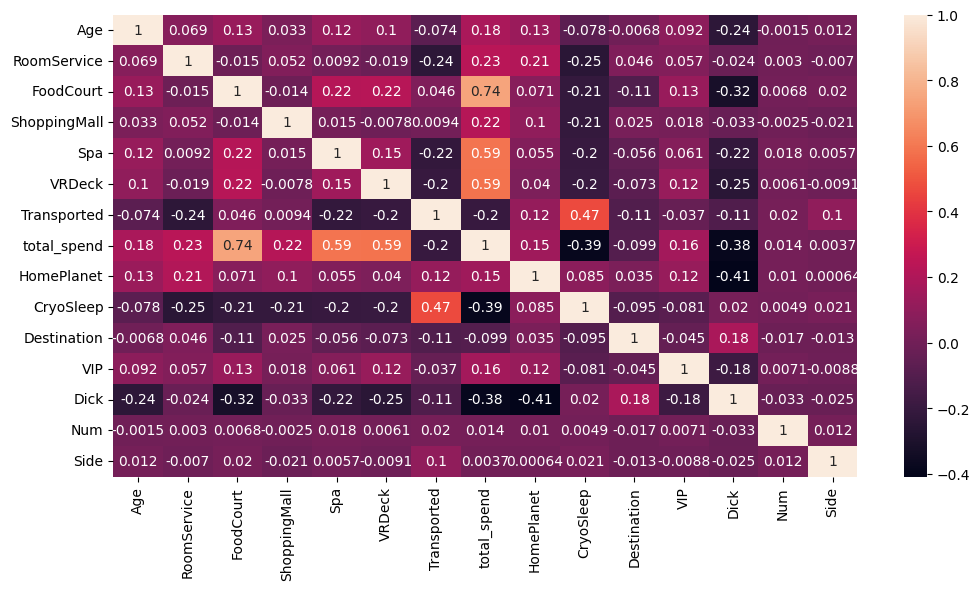

In [63]:
plt.figure(figsize=(12, 6))
sns.heatmap(temp1.corr(),annot=True)

<Axes: >

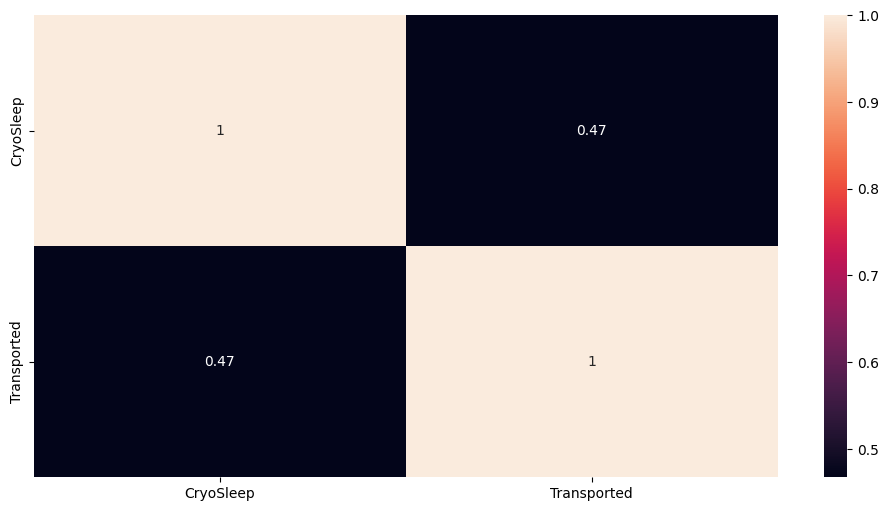

In [64]:
plt.figure(figsize=(12, 6))
sns.heatmap(temp1[['CryoSleep','Transported']].corr(),annot=True)

In [65]:
X=temp1.drop('Transported',axis=1)
y=temp1.Transported

In [66]:
X

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,total_spend,HomePlanet,CryoSleep,Destination,VIP,Dick,Num,Side
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,736.0,0.0,0.0,2.0,0.0,5.0,0.0,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,10383.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,5176.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1091.0,0.0,0.0,2.0,0.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,8536.0,1.0,0.0,0.0,1.0,0.0,1795.0,0.0
8689,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,548.0,1.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1873.0,0.0,0.0,2.0,0.0,6.0,551.0,1.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,4637.0,1.0,0.0,0.0,0.0,4.0,1385.0,1.0


In [67]:
test_Models(X,y)

[LightGBM] [Info] Number of positive: 3326, number of negative: 3193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1882
[LightGBM] [Info] Number of data points in the train set: 6519, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510201 -> initscore=0.040809
[LightGBM] [Info] Start training from score 0.040809
svm is :0.7838086476540939
Random forrest is :0.7856485740570377
Gradint boosting is : 0.7856485740570377
LGBM Classifier is : 0.7994480220791168
Xgboost Classifier is : 0.797148114075437
Catboost Classifier is : 0.8054277828886844


## -----------------------------------

In [76]:
temp1

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,total_spend,HomePlanet,CryoSleep,Destination,VIP,Dick,Num,Side
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1.0,736.0,0.0,0.0,2.0,0.0,5.0,0.0,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,10383.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,5176.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,1091.0,0.0,0.0,2.0,0.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0.0,8536.0,1.0,0.0,0.0,1.0,0.0,1795.0,0.0
8689,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,548.0,1.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1.0,1873.0,0.0,0.0,2.0,0.0,6.0,551.0,1.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0.0,4637.0,1.0,0.0,0.0,0.0,4.0,1385.0,1.0


In [88]:
def hyper_tuning(X, y, param_dist, model, seed=42, cv=5, scoring='accuracy', n_iter=50, test_size=0.0001):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.

    Parameters:
    - X, y: Features and target.
    - param_dist: Parameter distributions for RandomizedSearchCV.
    - model: The model to tune.
    - seed: Random state seed for reproducibility.
    - cv: Number of cross-validation folds.
    - scoring: Metric to optimize.
    - n_iter: Number of parameter settings to sample.
    - test_size: Test data size (0 to use all data for training).

    Returns:
    - The best estimator from RandomizedSearchCV.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed, shuffle=True)

    # Setup RandomizedSearchCV
    RSCV = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=seed,
        n_jobs=-1
    )

    # Train the model
    RSCV.fit(X_train, y_train)

    # Print the best parameters and scores
    print("Best Parameters:", RSCV.best_params_)
    print("Best Cross-Validation Accuracy:", RSCV.best_score_)
    print("Average Cross-Validation Accuracy:", RSCV.cv_results_['mean_test_score'].mean())
    
    return RSCV.best_estimator_

In [149]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'iterations': [200, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 64, 128],  # Number of splits for numerical features
    'random_strength': [1, 2, 5, 10]
}

# hyber_tuning CatBoostClassifier
cat_clf = hyper_tuning(X,y,param_dist,CatBoostClassifier(),n_iter=100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0:	learn: 0.6336414	total: 4.69ms	remaining: 933ms
1:	learn: 0.5739935	total: 9.71ms	remaining: 961ms
2:	learn: 0.5453394	total: 13.8ms	remaining: 907ms
3:	learn: 0.5220383	total: 18ms	remaining: 882ms
4:	learn: 0.5021836	total: 23.9ms	remaining: 933ms
5:	learn: 0.4838274	total: 28.2ms	remaining: 913ms
6:	learn: 0.4739857	total: 35.9ms	remaining: 990ms
7:	learn: 0.4675732	total: 41.1ms	remaining: 986ms
8:	learn: 0.4596533	total: 45.2ms	remaining: 959ms
9:	learn: 0.4548907	total: 49.3ms	remaining: 936ms
10:	learn: 0.4511197	total: 53.3ms	remaining: 915ms
11:	learn: 0.4445221	total: 58.5ms	remaining: 917ms
12:	learn: 0.4395941	total: 64.1ms	remaining: 922ms
13:	learn: 0.4369811	total: 67.9ms	remaining: 902ms
14:	learn: 0.4323077	total: 72.7ms	remaining: 896ms
15:	learn: 0.4303563	total: 76.2ms	remaining: 877ms
16:	learn: 0.4254831	total: 81.7ms	remaining: 879ms
17:	learn: 0.4232005	total: 85.6ms	remaining: 865ms
18:	learn: 0.

In [203]:
# Define the hyperparameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

# hyber_tuning XGboost
xgb_clf = hyper_tuning(X,y,param_dist,XGBClassifier(objective='binary:logistic'))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.07444444444444444, 'colsample_bytree': 0.9}
Best Cross-Validation Accuracy: 0.8108314251566189
Average Cross-Validation Accuracy: 0.8021858628231837


In [204]:
# Define the hyperparameter distribution
param_dist = {
    'n_estimators': [500],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,5,10],
    'max_features': ['sqrt', 'log2'],
    'criterion' : ["gini", "entropy", "log_loss"]
}

# hyber_tuning RandomForest
RF_clf=hyper_tuning(X,y,param_dist,RandomForestClassifier())

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'log_loss'}
Best Cross-Validation Accuracy: 0.8046732951765477
Average Cross-Validation Accuracy: 0.8023164084301257


In [205]:
# Define the hyperparameters grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# hyber_tuning GradientBoost
gb_clf = hyper_tuning(X,y,param_dist,GradientBoostingClassifier())

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}
Best Cross-Validation Accuracy: 0.8099013956853274
Average Cross-Validation Accuracy: 0.7999594056071715


In [115]:
# Define the hyperparameter distribution
param_dist = {
    'n_estimators': [100, 200, 500],
    'num_leaves': [20, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_samples': [5, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# hyber_tuning LGBM
lgbm = hyper_tuning(X,y,param_dist,LGBMClassifier(random_state=42),n_iter=200)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\Kerols\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Number of positive: 4377, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 8692, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503566 -> initscore=0.014266
[LightGBM] [Info] Start training from score 0.014266
Best Parameters: {'subsample': 1.0, 'num_leaves': 20, 'n_estimators': 200, 'min_child_samples': 5, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Cross-Validation Accuracy: 0.8108617639993886
Average Cross-Validation Accuracy: 0.8028845463611153


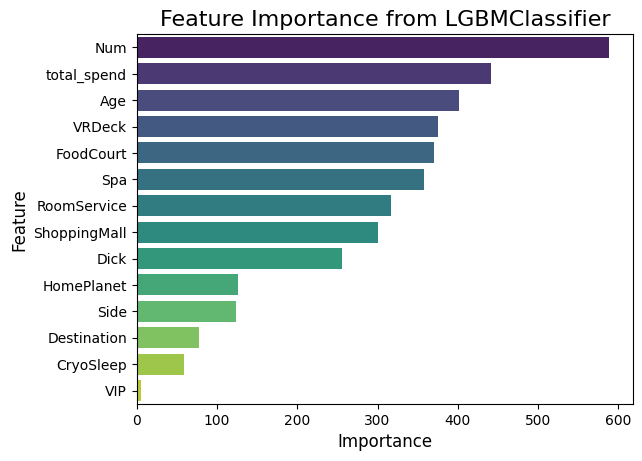

In [117]:
feature_importance = lgbm.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

sns.barplot(
    data=feature_importance_df, 
    x='Importance', 
    hue='Feature',
    y='Feature',
    palette='viridis',
    legend=False
)
plt.title('Feature Importance from LGBMClassifier', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [119]:
test_date=pd.read_csv('dataset/test.csv')

In [121]:
temp2=processing(test_date)

In [163]:
y_preds=lgbm.predict(temp2)

In [165]:
result = [True if i == 1 else False for i in y_preds]

In [167]:
kaggle_submission = pd.DataFrame({
    'PassengerId': test_date['PassengerId'],
    'Transported': result  
})

In [169]:
kaggle_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [171]:
kaggle_submission.Transported.value_counts()

Transported
True     2183
False    2094
Name: count, dtype: int64

In [173]:
kaggle_submission .to_csv('kaggle_submission.csv',index=False)